In [77]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [78]:
dataset = pd.read_csv('yahoo_dataset_gspc.csv')

In [79]:
dataset = dataset.dropna()
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
0,3 dic 2024,%5EGSPC,6042.97,6052.07,6033.39,6049.88,6049.88,4095000000
1,2 dic 2024,%5EGSPC,6040.11,6053.58,6035.33,6047.15,6047.15,4412470000
2,29 nov 2024,%5EGSPC,6003.98,6044.17,6003.98,6032.38,6032.38,2444420000
3,27 nov 2024,%5EGSPC,6014.11,6020.16,5984.87,5998.74,5998.74,3363340000
4,26 nov 2024,%5EGSPC,6000.03,6025.42,5992.27,6021.63,6021.63,3835170000
...,...,...,...,...,...,...,...,...
13847,8 ene 1970,%5EGSPC,0.00,93.47,91.99,92.68,92.68,10670000
13848,7 ene 1970,%5EGSPC,0.00,93.38,91.93,92.63,92.63,10010000
13849,6 ene 1970,%5EGSPC,0.00,93.81,92.13,92.82,92.82,11460000
13850,5 ene 1970,%5EGSPC,0.00,94.25,92.53,93.46,93.46,11490000


In [80]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset = actualizar_fecha(dataset, "Date")
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
13851,1970-01-02,%5EGSPC,0.00,93.54,91.79,93.00,93.00,8050000
13850,1970-01-05,%5EGSPC,0.00,94.25,92.53,93.46,93.46,11490000
13849,1970-01-06,%5EGSPC,0.00,93.81,92.13,92.82,92.82,11460000
13848,1970-01-07,%5EGSPC,0.00,93.38,91.93,92.63,92.63,10010000
13847,1970-01-08,%5EGSPC,0.00,93.47,91.99,92.68,92.68,10670000
...,...,...,...,...,...,...,...,...
4,2024-11-26,%5EGSPC,6000.03,6025.42,5992.27,6021.63,6021.63,3835170000
3,2024-11-27,%5EGSPC,6014.11,6020.16,5984.87,5998.74,5998.74,3363340000
2,2024-11-29,%5EGSPC,6003.98,6044.17,6003.98,6032.38,6032.38,2444420000
1,2024-12-02,%5EGSPC,6040.11,6053.58,6035.33,6047.15,6047.15,4412470000


In [81]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    #dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    #dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    #dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"]  #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"] #, "Symbol"]
fieldsPrice = ["average_price"]


dataset = calculateFields(dataset)
dataset

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,Symbol
0,1970-01-02,93.00,719164,92.665,4,1,1970,2,1,0,0,1,0,1,0
1,1970-01-05,93.46,719167,93.390,0,1,1970,5,2,0,0,1,0,4,0
2,1970-01-06,92.82,719168,92.970,1,1,1970,6,2,0,0,1,0,5,0
3,1970-01-07,92.63,719169,92.655,2,1,1970,7,2,0,0,1,0,6,0
4,1970-01-08,92.68,719170,92.730,3,1,1970,8,2,0,0,1,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13847,2024-11-26,6021.63,739216,6008.845,1,11,2024,331,48,0,0,4,3,20053,0
13848,2024-11-27,5998.74,739217,6002.515,2,11,2024,332,48,0,0,4,3,20054,0
13849,2024-11-29,6032.38,739219,6024.075,4,11,2024,334,48,0,0,4,3,20056,0
13850,2024-12-02,6047.15,739222,6044.455,0,12,2024,337,49,0,0,4,0,20059,0


In [82]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [83]:
from datetime import datetime

def generateRandomDate():
    max_date = pd.to_datetime(dataset['Date'].max())
    max_valid_date = max_date - pd.DateOffset(years=3)
    min_valid_date = pd.to_datetime(dataset['Date'].min())

    delta = (max_valid_date - min_valid_date).days
    random_days = np.random.randint(0, delta + 1)
    random_date0 = min_valid_date + pd.Timedelta(days=random_days)
    return random_date0

random_date = datetime.strptime("01/01/2018", "%d/%m/%Y") #generateRandomDate()

In [84]:
filtered_df = dataset[(dataset['Date'] >= random_date)]

In [85]:
#testRanges = [1, 91, 181, 271, 361, 451, 541, 631, 721, 791, 881, 971, 1061]
testRanges = [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
train_days = 365
nJobs = 5
nEstimators = 100
block_size = 30

In [86]:
def getTrainTest(filtered_df0, pivote_date0, head=29):
    max_train_day = pivote_date0 + pd.DateOffset(days=train_days)
    blockDf = filtered_df0[(filtered_df0['Date'] >= pivote_date0) & (filtered_df0['Date'] <= max_train_day)]
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_train0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_train0 = aux[fieldsPrice].copy()
    
    #Se toman los siguientes 29 días hábiles
    blockDf = filtered_df0[filtered_df0["Date"] > max_train_day].head(head)
    #filtered_df0[(filtered_df0['Date'] > max_train_day) & (filtered_df0['Date'] <= max_test_day)]
    
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_test0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test0 = aux[fieldsPrice].copy()

    return X_train0, Y_train0, X_test0, Y_test0

In [87]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

resultBasicRF = dict()
resultNonOverlapping = dict()
resultMovingBlock = dict()
resultCircularBlock = dict()

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

pivote_date = random_date
for testRange in testRanges:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    basicRFPrecision[testRange] = rmse0
    resultBasicRF[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionNonOverlapping[testRange] = rmse0
    resultNonOverlapping[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionMovingBlock[testRange] = rmse0
    resultMovingBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    precisionCircularBlock[testRange] = rmse0
    resultCircularBlock[testRange] = (Y_test["average_price"].values[0], y_pred[0])
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

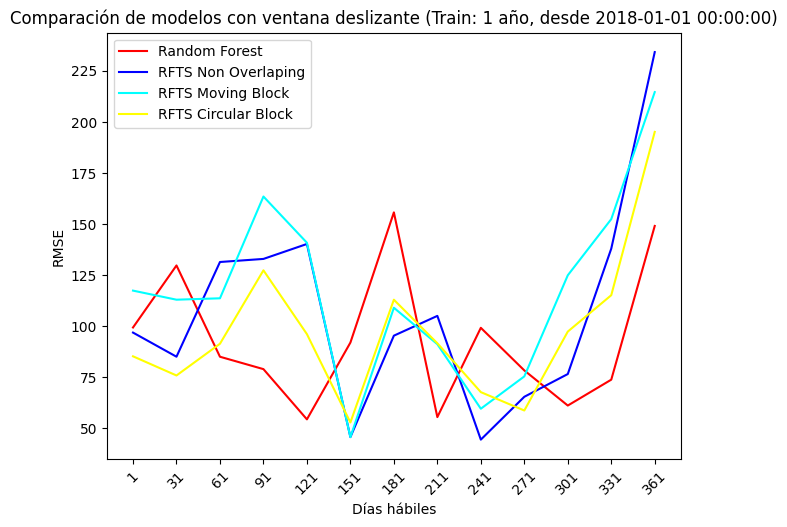

In [89]:
labels = list(basicRFPrecision.keys())
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())


bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    
plt.legend()

plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("RMSE")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [90]:
expectedValuesRf = []
predictedValuesRf = []
predictedValuesRftsNO = []
predictedValuesRftsMB = []
predictedValuesRftsCB = []

In [91]:

X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, random_date, max(testRanges))
basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
basicRF.fit(X_train, Y_train)
y_pred = basicRF.predict(X_test)
expectedValuesRf = Y_test["average_price"].tolist() 
predictedValuesRf = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsNO = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsMB = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsCB = y_pred



c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


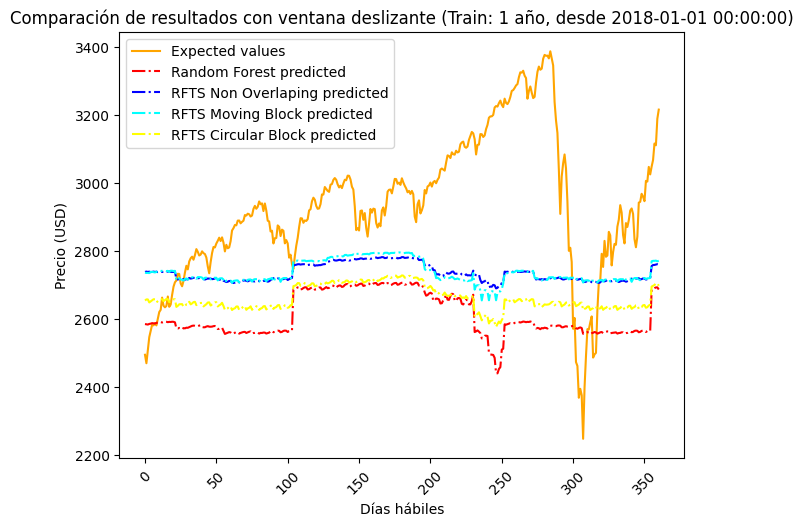

In [92]:
bp = plt.plot(expectedValuesRf, color='orange', label="Expected values", linestyle='-')
bp0 = plt.plot(predictedValuesRf, color='red', label="Random Forest predicted", linestyle='-.')
bp1 = plt.plot(predictedValuesRftsNO, color='blue', label="RFTS Non Overlaping predicted", linestyle='-.')
bp2 = plt.plot(predictedValuesRftsMB, color='cyan', label="RFTS Moving Block predicted", linestyle='-.')
bp3 = plt.plot(predictedValuesRftsCB, color='yellow', label="RFTS Circular Block predicted", linestyle='-.')


plt.legend()

#plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("Precio (USD)")
plt.title(f"Comparación de resultados con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [94]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

predictedBasicRF_2 = []
predictedNonOverlapping_2 = []
predictedMovingBlock_2 = []
predictedCircularBlock_2 = []

predictedBasicRF = []
predictedNonOverlapping = []
predictedMovingBlock = []
predictedCircularBlock = []

In [95]:
expectedValuesMean = []
expectedValues = []
pivote_date = random_date
for testRange in testRanges[:6]:
    X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, pivote_date)
    basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test.head(7))
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    expectedValuesMean.append(sum(Y_test.head(7)["average_price"].tolist()) / len(Y_test.head(7)["average_price"].tolist()))
    expectedValues += Y_test.head(7)["average_price"].tolist()
    basicRFPrecision[testRange] = rmse0
    X_test0 = X_test.tail(22)
    Y_test0 = Y_test.tail(22)
    y_pred = basicRF.predict(X_test0.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test0.head(7)["average_price"].tolist()) / len(Y_test0.head(7)["average_price"].tolist()))
    expectedValues += Y_test0.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 7] = rmse0
    X_test1 = X_test.tail(15)
    Y_test1 = Y_test.tail(15)
    y_pred = basicRF.predict(X_test1.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test1.head(7)["average_price"].tolist()) / len(Y_test1.head(7)["average_price"].tolist()))
    expectedValues += Y_test1.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 14] = rmse0
    X_test2 = X_test.tail(8)
    Y_test2 = Y_test.tail(8)
    y_pred = basicRF.predict(X_test2.head(7))
    predictedBasicRF.append(sum(y_pred) / len(y_pred))
    predictedBasicRF_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    expectedValuesMean.append(sum(Y_test2.head(7)["average_price"].tolist()) / len(Y_test2.head(7)["average_price"].tolist()))
    expectedValues += Y_test2.head(7)["average_price"].tolist()
    basicRFPrecision[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionNonOverlapping[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionNonOverlapping[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionNonOverlapping[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedNonOverlapping.append(sum(y_pred) / len(y_pred))
    predictedNonOverlapping_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionNonOverlapping[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionMovingBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionMovingBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionMovingBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedMovingBlock.append(sum(y_pred) / len(y_pred))
    predictedMovingBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionMovingBlock[testRange + 21] = rmse0

    rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
    rfts.fit(X_train, Y_train)
    y_pred = rfts.predict(X_test.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test.head(7), y_pred))
    precisionCircularBlock[testRange] = rmse0
    y_pred = rfts.predict(X_test0.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test0.head(7), y_pred))
    precisionCircularBlock[testRange + 7] = rmse0
    y_pred = rfts.predict(X_test1.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test1.head(7), y_pred))
    precisionCircularBlock[testRange + 14] = rmse0
    y_pred = rfts.predict(X_test2.head(7))
    predictedCircularBlock.append(sum(y_pred) / len(y_pred))
    predictedCircularBlock_2 += list(y_pred)
    rmse0 = sqrt(mean_squared_error(Y_test2.head(7), y_pred))
    precisionCircularBlock[testRange + 21] = rmse0
    
    pivote_date = random_date + pd.DateOffset(days=testRange)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

In [96]:
ticks001 = []
for testRange in testRanges[:6]:
    ticks001.append("")
    ticks001.append(str(testRange))
    for i in range(5):
        ticks001.append("")
    ticks001.append(str(testRange + 7))
    for i in range(6):
        ticks001.append("")
    ticks001.append(str(testRange + 14))
    for i in range(6):
        ticks001.append("")
    ticks001.append(str(testRange + 21))
    for i in range(8):
        ticks001.append("")

rmse_y = []
prediction_y = []
for i in testRanges[:6]:
    rmse_y += [i]
    for k in range(7):
        prediction_y += [i + k]
    rmse_y += [i + 7]
    for k in range(7):
        prediction_y += [i + k + 7]
    rmse_y += [i + 14]
    for k in range(7):
        prediction_y += [i + k + 14]
    rmse_y += [i + 21]
    for k in range(7):
        prediction_y += [i + k + 21]

In [97]:
def calculate_percent_error(rmse, predicted):
    percent_error = []
    k = 0
    for i in range(len(rmse)):
        exp = 0
        for x in range(7):
            try:
                exp += predicted[k]
                k += 1
            except:
                print()
        exp /= 7
        percent_error.append((rmse[i] / exp) * 100) 
    return percent_error

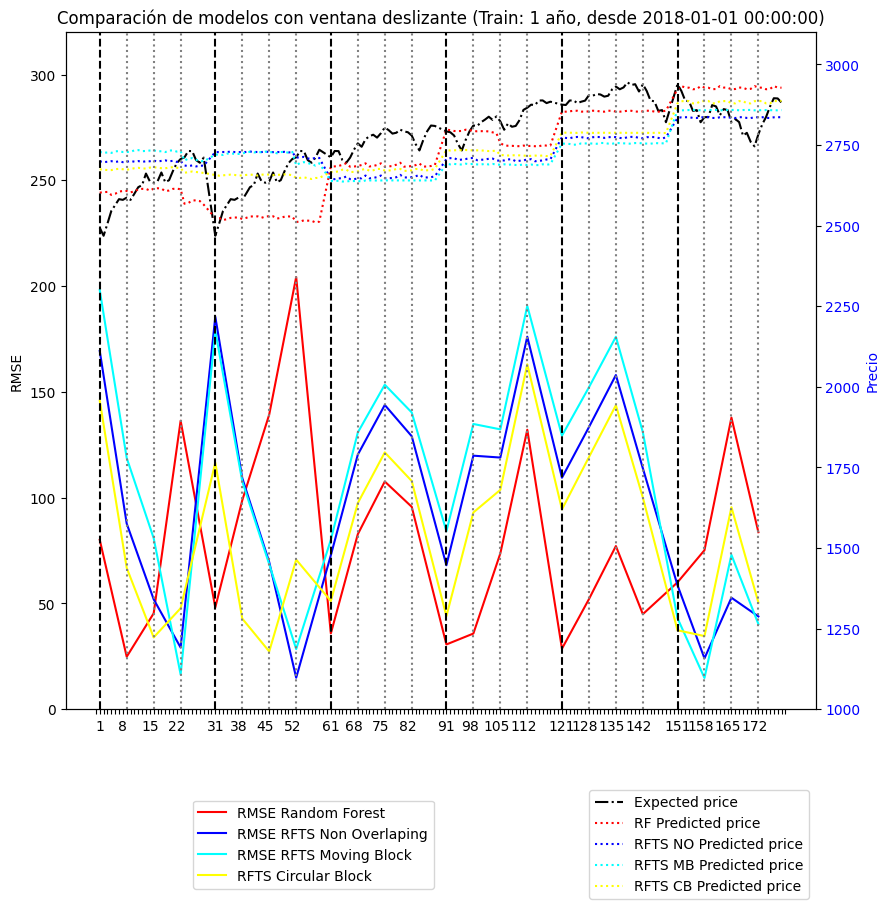

In [98]:
all_arr0 = list(basicRFPrecision.values())
all_arr = list(precisionNonOverlapping.values())
all_arr1 = list(precisionMovingBlock.values())
all_arr2 = list(precisionCircularBlock.values())

fig, ax1 = plt.subplots(figsize=(9, 9))
bp3 = ax1.plot(rmse_y, all_arr0, color='red', label="RMSE Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = ax1.plot(rmse_y, all_arr, color='blue', label="RMSE RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = ax1.plot(rmse_y, all_arr1, color='cyan', label="RMSE RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = ax1.plot(rmse_y, all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.2))
plt.ylabel("RMSE")
ax1.set_ylim(0, 320)
# Segundo eje
ax2 = ax1.twinx()
ax2.plot(prediction_y, expectedValues, color='black', label="Expected price", linestyle='-.')
ax2.plot(prediction_y, predictedBasicRF_2, color='red', label="RF Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedNonOverlapping_2, color='blue', label="RFTS NO Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedMovingBlock_2, color='cyan', label="RFTS MB Predicted price", linestyle=':')
ax2.plot(prediction_y, predictedCircularBlock_2, color='yellow', label="RFTS CB Predicted price", linestyle=':')
ax2.set_ylabel('Precio', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim(1000, 3100)
plt.legend(loc='center right', bbox_to_anchor=(1, -0.2))


plt.xticks(range(0, len(ticks001)), ticks001)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.title(f"Comparación de modelos con ventana deslizante (Train: 1 año, desde {random_date})")
plt.xticks(rotation=-45)

i = 0
for testRange in testRanges[:6]:
    plt.axvline(x=testRange, color='black', linestyle='--')
    for k in range(3):
        plt.axvline(x=testRange + (k + 1) * 7, color='grey', linestyle=':')
    i+=1

plt.show()

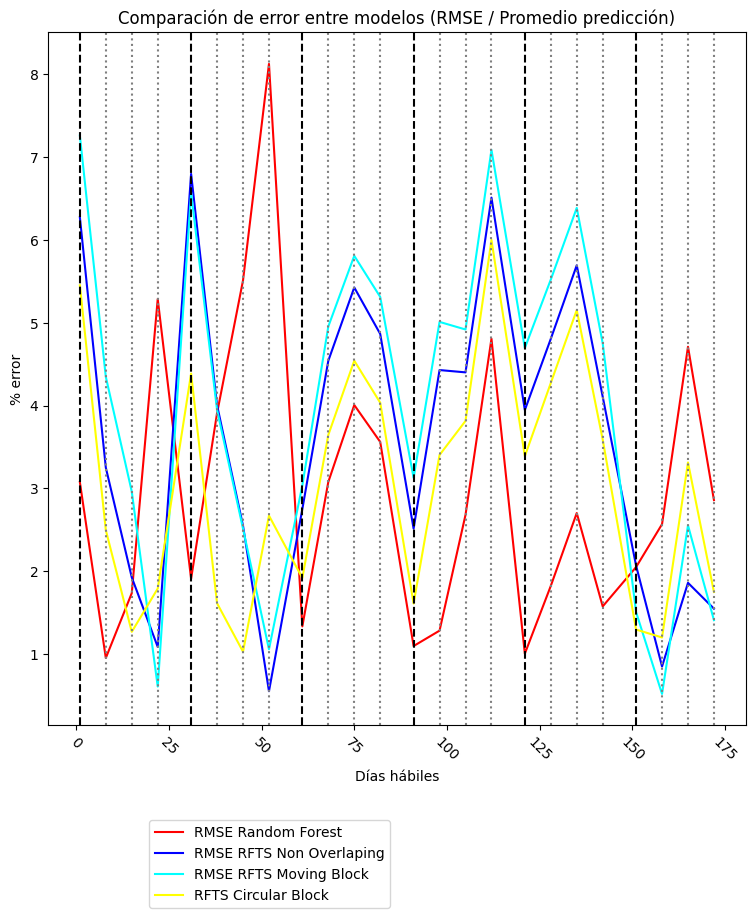

In [99]:
rf_error = calculate_percent_error(all_arr0, predictedBasicRF_2)
rfts_no_error = calculate_percent_error(all_arr, predictedNonOverlapping_2)
rfts_mb_error = calculate_percent_error(all_arr1, predictedMovingBlock_2)
rfts_cb_error = calculate_percent_error(all_arr2, predictedCircularBlock_2)

fig, ax1 = plt.subplots(figsize=(9, 9))
bp3 = ax1.plot(rmse_y, rf_error, color='red', label="RMSE Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
bp0 = ax1.plot(rmse_y, rfts_no_error, color='blue', label="RMSE RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = ax1.plot(rmse_y, rfts_mb_error, color='cyan', label="RMSE RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = ax1.plot(rmse_y, rfts_cb_error, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
plt.legend(loc='center right', bbox_to_anchor=(0.5, -0.2))
plt.ylabel("% error")
plt.xlabel("Días hábiles")
plt.title(f"Comparación de error entre modelos (RMSE / Promedio predicción)")
plt.xticks(rotation=-45)

i = 0
for testRange in testRanges[:6]:
    plt.axvline(x=testRange, color='black', linestyle='--')
    for k in range(3):
        plt.axvline(x=testRange + (k + 1) * 7, color='grey', linestyle=':')
    i+=1